In [1]:
import pandas as pd 
import numpy as np
import math as mt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import qgrid
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = "{:,.2f}".format
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

## FUNCTIONS

In [2]:
def fuzzy_c_means(df, k=4, m=2, max_iter=1000, error=1e-5, distance_metric=None, distance_metric_args=()):
    """
    Perform Fuzzy C-means clustering with a custom distance metric.

    :param df: DataFrame containing the dataset.
    :param k: The number of clusters. Default is 4.
    :param m: Fuzziness coefficient. Default is 2.
    :param max_iter: Maximum number of iterations. Default is 100.
    :param error: Convergence criteria threshold. Default is 1e-5.
    :param distance_metric: Function for distance computation. Default is Euclidean.
    :param distance_metric_args: Additional arguments for the distance_metric function.
    :return: Tuple containing the cluster centers and the membership weights.
    """
    
    np.random.seed(42)  # Replace 42 with your chosen seed

    # Ensure the DataFrame does not contain infs or NaNs
    if df.isnull().values.any() or np.isinf(df.values).any():
        raise ValueError("Input dataframe cannot contain NaNs or infinite values")

    n = len(df)
    d = len(df.columns)

    # Initialize centroids randomly
    C = np.random.rand(k, d)

    # Initialize membership matrix
    weight = np.random.dirichlet(np.ones(k), size=n)

    # Initialize prev_weight for convergence check
    prev_weight = np.copy(weight)

    # Set the default distance metric if none is provided
    if distance_metric is None:
        distance_metric = lambda c, x: np.linalg.norm(c - x, axis=1)

    # Fuzzy C-Means algorithm
    iteration_count = 0
    while True:
        iteration_count += 1

        # Update Centroids
        for j in range(k):
            denominator = np.sum(np.power(weight[:, j], m))
            numerator = np.dot(np.power(weight[:, j], m), df.to_numpy())
            C[j] = numerator / denominator

        # Update Membership Matrix
        for i in range(n):
            x_i = df.iloc[i].to_numpy()  # Convert to numpy array
            distances = distance_metric(C, x_i, *distance_metric_args)  # Use the provided distance metric
            for j in range(k):
                # Protect against division by zero
                if distances[j] == 0:
                    distances[j] = np.finfo(np.float64).tiny
                # Update the weight
                weight[i, j] = 1 / np.sum((distances[j] / np.maximum(distances, np.finfo(np.float64).tiny)) ** (2 / (m - 1)))

        # Check convergence
        if np.linalg.norm(weight - prev_weight) < error:
            print("Algorithm converged after", iteration_count, "iterations.")
            break
        prev_weight = np.copy(weight)

        # Break if max iterations have been reached
        if iteration_count >= max_iter:
            print("Reached maximum iterations without convergence.")
            break

    return C, weight

# Usage:
# Ensure the dataframe does not contain NaNs or infinite values before calling the function.
# df = df.dropna()  # Drop NaN values if necessary
# df.replace([np.inf, -np.inf], np.nan).dropna()  # Replace infs with NaN and then drop

In [3]:
def weighted_euclidean(c, x, w):
    """Calculate weighted Euclidean distance."""
    diff_squared = (c - x) ** 2
    weighted_diff_squared = diff_squared * w
    distance = np.sqrt(np.sum(weighted_diff_squared, axis=1))
    return distance
# Specify your weights for the weighted Euclidean distance
#weights_for_distance = np.array([1, 1, 1,1])  # Replace with your actual weights
# Call the fuzzy_c_means function with the weighted Euclidean distance metric
#centroids, membership_weights = fuzzy_c_means(transformed_dimensions, distance_metric=weighted_euclidean, 
#distance_metric_args=(weights_for_distance,))

# Define the distance function
def manhattan_distance(c, x):
    return np.array([cityblock(c_i, x) for c_i in c])
#centroids, membership_weights = fuzzy_c_means(df, distance_metric=manhattan_distance)

# Define the distance function
def chebyshev_distance(c, x):
    return np.array([chebyshev(c_i, x) for c_i in c])

# Use the distance function in fuzzy_c_means
#centroids, membership_weights = fuzzy_c_means(df, distance_metric=chebyshev_distance)


# Define the distance function with a custom p-value for the Minkowski metric
def minkowski_distance(c, x, p=3):
    return np.array([minkowski(c_i, x, p) for c_i in c])

# Use the distance function in fuzzy_c_means
#centroids, membership_weights = fuzzy_c_means(df, distance_metric=minkowski_distance, distance_metric_args=(3,))

def cosine_distance(c, x):
    # Calculate cosine distance between a set of centroids and a data point
    # c is an array where each row represents a centroid
    # x is a single data point
    return np.array([1 - cosine(c_i, x) for c_i in c])

def spearman_distance(c, x):
    # Ensure centroids 'c' is a 2D array
    if c.ndim == 1:
        c = c.reshape(1, -1)
    
    distances = np.zeros(c.shape[0])
    
    # Convert the single data point 'x' and each centroid to ranks
    #x_ranks = stats.rankdata(x)
    
    for j, c_j in enumerate(c):
        # Convert each centroid to ranks
        c_j_ranks = stats.rankdata(c_j)
        # Compute Spearman's rank correlation and convert it to distance
        correlation, _ = stats.spearmanr(x, c_j_ranks)
        distance = 1 - correlation
        distances[j] = distance
            
    return distances

In [4]:
def create_cluster_boxplots_v3(fuzzy_clusters, assigned_clusters):
    if 'Cluster' not in fuzzy_clusters.columns:
        fuzzy_clusters['Cluster'] = assigned_clusters
    
    
    fuzzy_clusters= fuzzy_clusters.sort_values(by='Cluster',ascending=False)
    
    num_clusters = ['High PC1 & Low PC2', 'Low PC1 & Low PC2', 'High PC1 & High PC2',
       'Low PC1 & High PC2']

    # Initialize the figure
    plt.figure(figsize=(11, 8))

    # Create a supertitle for all subplots
    plt.suptitle('Distribution of Clusters across Dimensions', fontsize=14, ha='left', x=0, y=1.16)
    title= "Distribution_of_Clusters_across_Dimensions"   

    for i, feature in enumerate(fuzzy_clusters.columns[:-3]):
        ax = plt.subplot(len(fuzzy_clusters.columns) // 2, 2, i + 1)
        num_clusters = fuzzy_clusters['Cluster'].unique()
        # Prepare the data for boxplot
        data_to_plot = [fuzzy_clusters.loc[fuzzy_clusters['Cluster'] == cluster_label, feature].values for cluster_label in num_clusters]
        num_clusters = fuzzy_clusters['Cluster'].nunique()
        # Create the boxplot with specified aesthetics
        bp = ax.boxplot(data_to_plot,
                        positions=np.arange(num_clusters),
                        widths=0.4,
                        patch_artist=True,
                        boxprops=dict(facecolor="white", edgecolor="black"),
                        whiskerprops=dict(color="black"),
                        medianprops=dict(color="black"),
                        capprops=dict(color="black"))

        # Draw blue lines between medians
        medians = [np.median(dat) for dat in data_to_plot]
        ax.plot(np.arange(4), medians, 'o-', color='blue', markersize=4, zorder=3, linewidth=2.95, alpha=0.35)
        num_clusters = fuzzy_clusters['Cluster'].unique()
        ax.set_title(f'{feature}')
        ax.set_xticks(np.arange(4))
        ax.set_xticklabels([f'{i}' for i in (num_clusters)])
        ax.set_ylabel('')

    plt.tight_layout(rect=[0, 0.03, 1.3, 1.2])
    plt.subplots_adjust(wspace=0.13, hspace=0.20)  # Adjust the spacing to make sure everything fits

    plt.show()


In [5]:
def create_uniform_cluster_boxplots_v3(df, assigned_clusters, features):
    """
    Create a grid of boxplots for each cluster in the dataframe with specified features,
    where all boxplots have a white fill and black edges and the '0' value is visible on the y-axis.

    Parameters:
    df (DataFrame): The DataFrame containing the data.
    assigned_clusters (array-like): An array of cluster assignments for each row in df.
    features (list of str): A list of column names to be used for plotting the boxplots.
    """
    # Add cluster assignments to the DataFrame if not already present
    if 'Cluster' not in df.columns:
        df['Cluster'] = assigned_clusters
        
    df= df.sort_values(by='Cluster',ascending=False)
    
    # Define the number of unique clusters
    num_clusters = ['Low PC1 & High PC2', 'High PC1 & High PC2',
  'Low PC1 & Low PC2',  'High PC1 & Low PC2'
 ]
    
    # Create a figure with subplots
    nrows = int(np.ceil(np.sqrt(3)))
    ncols = nrows if 3 > nrows * (nrows - 1) else nrows - 1
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(11, 8))  # Adjust figsize as needed
    
    plt.suptitle('Distribution of Dimensions across Clusters', fontsize=14, ha='left',  x=0, y=1.16)
    title = 'Distribution_of_Dimensions_across_Clusters'

    # Flatten the axes array for easy iteration
    axes_flat = axes.flatten()
    # Plot box plots for each cluster
    for i, j in enumerate(num_clusters):
        cluster_data = df[df['Cluster'] == j]  # Filter data for the i-th cluster
        boxplot_data = [cluster_data[feature].values for feature in features]  # Collect data for all features

        # Create the boxplot with specified aesthetics
        bp = axes_flat[i].boxplot(boxplot_data,
                                  vert=True,  # Vertical box plots
                                  patch_artist=True,  # Fill with color
                                  labels=features,  # Use feature names as labels
                                  widths=0.4,  # Width of the boxplot
                                  boxprops=dict(facecolor="white", edgecolor="black"),
                                  whiskerprops=dict(color="black"),
                                  medianprops=dict(color="black"),
                                  capprops=dict(color="black"))

        # Set titles for subplots
        axes_flat[i].set_title(f'{j}')
        
        # Explicitly set the y-axis to start at 0
        axes_flat[i].set_ylim(bottom=min(0, axes_flat[i].get_ylim()[0]))

    # Hide any unused subplots
    for j in range(4, len(axes_flat)):
        fig.delaxes(axes_flat[j])

    plt.tight_layout(rect=[0, 0.03, 1.3, 1.2])
    plt.subplots_adjust(wspace=0.13, hspace=0.20)  # Adjust the spacing to make sure everything fits
    plt.show()


In [6]:
def calculate_xb(data, centroids, membership_matrix, m=2):
    """
    Calculate the Xie-Beni Index (XB) for the clustering.

    The XB index is a ratio of the compactness to the separation of the clusters,
    with lower values indicating better clustering performance.
    
    Xie, X. L., & Beni, G. (1991). A validity measure for fuzzy clustering. 
    IEEE Transactions on Pattern Analysis & Machine Intelligence, 13(08), 841-847.

    Parameters:
    - data: 2D NumPy array with the dataset points.
    - centroids: 2D NumPy array where each row is a centroid.
    - membership_matrix: 2D NumPy array with membership degrees.
    - m: Fuzziness parameter, typically 2.

    Returns:
    - xb: Xie-Beni Index as a float.
    
    """
    # If data and centroids are DataFrames, convert to NumPy arrays
    if isinstance(data, pd.DataFrame):
        data = data.values
    if isinstance(centroids, pd.DataFrame):
        centroids = centroids.values

    # Calculate the Euclidean distance matrix
    euclidean_dist_matrix = np.array([[np.linalg.norm(data_point - centroid) for centroid in centroids]
                                      for data_point in data])
    
    # Calculate the Euclidean distance matrix between each data point and each centroid
    euclidean_dist_matrix = np.array([[np.linalg.norm(data[i] - centroids[j]) for j in range(centroids.shape[0])]
                                      for i in range(data.shape[0])])
    # Numerator of XB index: sum of squared distances weighted by membership values
    numerator = np.sum((membership_matrix ** m) * (euclidean_dist_matrix ** 2))
    # Denominator of XB index: smallest distance between any two centroids, squared
    cluster_separation = np.min([np.linalg.norm(centroids[i] - centroids[j])
                                 for i in range(centroids.shape[0])
                                 for j in range(centroids.shape[0]) if i != j]) ** 2
    # Number of data points
    n = data.shape[0]
    xb = numerator / (n * cluster_separation)
    return xb


In [7]:

# 1. Partition Coefficient (PC)
def partition_coefficient(membership_matrix):
    return np.sum(membership_matrix**2) / membership_matrix.shape[0]

# 2. Normalized Partition Coefficient (NPC)
def normalized_partition_coefficient(membership_matrix):
    k = membership_matrix.shape[1]
    return (k / (k - 1)) * (1 - partition_coefficient(membership_matrix))

# 3. Fuzzy Hypervolume (FHV)
def fuzzy_hypervolume(membership_matrix, data, centroids, m=2):
        
    if isinstance(data, pd.DataFrame):
        data = data.values
    if isinstance(centroids, pd.DataFrame):
        centroids = centroids.values
    
    distance_matrix = np.sum((data[:, np.newaxis] - centroids)**2, axis=2)
    return np.sum((membership_matrix**m) * distance_matrix)

# 4. Fukuyama-Sugeno Index (FS)
def fukuyama_sugeno(membership_matrix, data, centroids, m=2):
    
    if isinstance(data, pd.DataFrame):
        data = data.values
    if isinstance(centroids, pd.DataFrame):
        centroids = centroids.values
    
    u_m = membership_matrix**m
    v = np.sum(u_m[:, :, np.newaxis] * data[:, np.newaxis], axis=0) / np.sum(u_m, axis=0)[:, np.newaxis]
    return np.sum(np.sqrt(np.sum((data - v[np.argmax(membership_matrix, axis=1)])**2, axis=1)))

# Note: XB is skipped as you've already provided it

# 5. Beringer-Hullermeier Index (BH) - Assumed typical definition
def beringer_hullermeier(membership_matrix, data, centroids, m=2):
    
    if isinstance(data, pd.DataFrame):
        data = data.values
    if isinstance(centroids, pd.DataFrame):
        centroids = centroids.values
    
    distance_matrix = np.sum((data[:, np.newaxis] - centroids)**2, axis=2)
    intra_cluster = np.sum((membership_matrix**m) * distance_matrix)
    inter_cluster = np.sum((1 - membership_matrix) * distance_matrix)
    return intra_cluster / inter_cluster

# 6. Bouguessa-Wang-Sun index (BWS) - Assumed typical definition
def bouguessa_wang_sun(membership_matrix, data, centroids, m=2):
    
    if isinstance(data, pd.DataFrame):
        data = data.values
    if isinstance(centroids, pd.DataFrame):
        centroids = centroids.values
    
    
    distance_matrix = np.sum((data[:, np.newaxis] - centroids)**2, axis=2)
    max_intra_cluster = np.max(np.sum((membership_matrix**m) * distance_matrix, axis=1))
    min_inter_cluster = np.min(np.sum((1 - membership_matrix) * distance_matrix, axis=1))
    return max_intra_cluster / min_inter_cluster

def calculate_ce(membership_matrix):
    """
    Calculate the Classification Entropy (CE) for the clustering.

    The CE measures the amount of disorder or fuzziness in the partitioning.
    Lower values indicate a clearer distribution of memberships across clusters.

    Parameters:
    - membership_matrix: 2D NumPy array with membership degrees.

    Returns:
    - ce: Classification Entropy as a float.
    """
    # Compute the entropy
    ce = -np.sum(membership_matrix * np.log(membership_matrix)) / membership_matrix.shape[0]
    return ce


In [8]:
transformed_dimensions = pd.read_csv('transformed_dimensions.csv')

In [9]:
df = transformed_dimensions.copy()

In [10]:
df.head()

,Annual Sales,Seasonality,Capacity Ins.,Backorder T.
0,0.92,0.75,0.79,0.21
1,0.94,0.50,0.89,0.11
2,0.95,0.71,0.89,0.19
3,0.89,0.68,0.92,0.16
4,0.96,0.78,0.91,0.20


## PCA

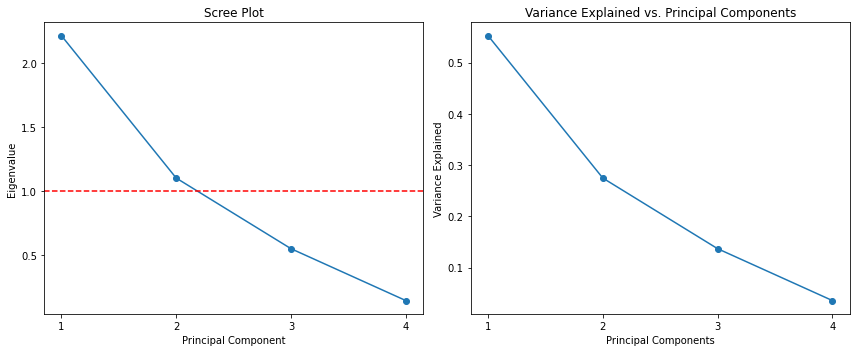

,Dimension 1,Dimension 2
0,1.06,-0.60
1,1.73,-1.04
2,1.39,-0.62
3,1.37,-0.69
4,1.32,-0.52


,PC1,PC2
Annual Sales,0.63,-0.11
Seasonality,-0.52,0.22
Capacity Ins.,0.58,0.28
Backorder T.,0.02,0.93


In [11]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
# Apply PCA
pca = PCA(n_components=4)  # Reduce to two dimensions
principal_components = pca.fit_transform(df_scaled)
loadings = pca.components_.T
loadings_df = pd.DataFrame(data=loadings, index=df.columns, columns=['PC1', 'PC2','PC3','PC4'])
principal_components[:, 0] = -principal_components[:, 0]
loadings_df['PC1'] = -loadings_df['PC1']
explained_variance = pca.explained_variance_
explained_variance_ratio = pca.explained_variance_ratio_
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.reset_orig()
# Scree Plot on the first subplot
axs[0].plot(range(1, len(explained_variance) + 1), explained_variance, 'o-')
axs[0].set_title('Scree Plot')
axs[0].set_xlabel('Principal Component')
axs[0].set_ylabel('Eigenvalue')
axs[0].grid(False)
axs[0].axhline(y=1, color='r', linestyle='--')
axs[0].set_xticks(range(1, len(explained_variance) + 1))
axs[1].plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, 'o-')
axs[1].set_title('Variance Explained vs. Principal Components')
axs[1].set_xlabel('Principal Components')
axs[1].set_ylabel('Variance Explained')
axs[1].set_xticks(range(1, len(explained_variance) + 1))
pca = PCA(n_components=2)  # Reduce to two dimensions
principal_components = pca.fit_transform(df_scaled)
loadings = pca.components_.T
loadings_df = pd.DataFrame(data=loadings, index=df.columns, columns=['PC1', 'PC2'])
principal_components[:, 0] = -principal_components[:, 0]
loadings_df['PC1'] = -loadings_df['PC1']
plt.tight_layout()
plt.show()
pca_df = pd.DataFrame(data=principal_components, columns=['Dimension 1', 'Dimension 2'])
display(pca_df.head())
loadings = pca.components_.T
loadings_df = pd.DataFrame(data=loadings, index=df.columns, columns=['PC1', 'PC2'])
display(loadings_df.head())

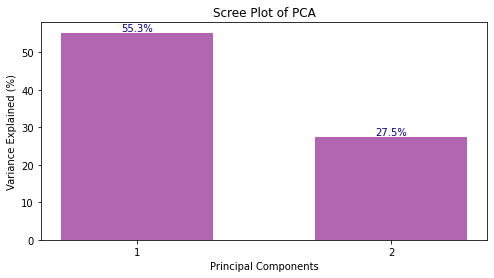

In [12]:
explained_variance_ratio = pca.explained_variance_ratio_ * 100  # Convert to percentages
fig, ax = plt.subplots(figsize=(8, 4))
x_ticks = np.arange(len(explained_variance_ratio)) + 1
ax.bar(x_ticks, explained_variance_ratio, color='purple', alpha=0.6,width=0.6)
for i, v in enumerate(explained_variance_ratio):
    ax.text(i + 1, v + 0.50, f"{v:.1f}%", horizontalalignment='center', color='darkblue')
ax.set_title('Scree Plot of PCA')
ax.set_xlabel('Principal Components')
ax.set_ylabel('Variance Explained (%)')
ax.set_xticks(x_ticks) 

plt.show()


In [13]:
pca_dimensions = transformed_dimensions.join(pca_df)

In [14]:
pca_dimensions.head(3)

,Annual Sales,Seasonality,Capacity Ins.,Backorder T.,Dimension 1,Dimension 2
0,0.92,0.75,0.79,0.21,1.06,-0.60
1,0.94,0.50,0.89,0.11,1.73,-1.04
2,0.95,0.71,0.89,0.19,1.39,-0.62


In [15]:
transformed_dimensions.head()
pca_df_2 = pca_dimensions[['Dimension 1','Dimension 2']]

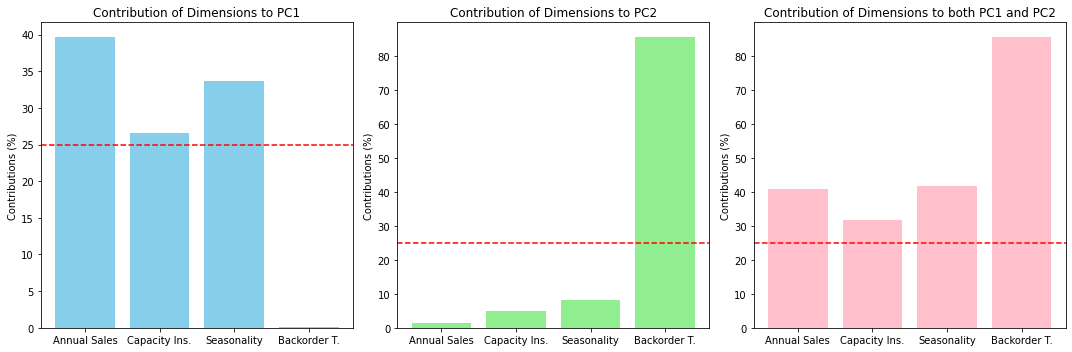

In [16]:
contributions = (loadings ** 2) * 100  # Convert to percentage
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
variables = ['Annual Sales', 'Capacity Ins.', 'Seasonality', 'Backorder T.']
axes[0].bar(variables, contributions[:, 0], color='skyblue')
axes[0].set_title('Contribution of Dimensions to PC1')
axes[0].set_ylabel('Contributions (%)')
axes[0].axhline(y=25, color='r', linestyle='--')
axes[1].bar(variables, contributions[:, 1], color='lightgreen')
axes[1].set_title('Contribution of Dimensions to PC2')
axes[1].set_ylabel('Contributions (%)')
axes[1].axhline(y=25, color='r', linestyle='--')
combined_contributions = np.sum(contributions, axis=1)
axes[2].bar(variables, combined_contributions, color='pink')
axes[2].set_title('Contribution of Dimensions to both PC1 and PC2')
axes[2].set_ylabel('Contributions (%)')
axes[2].axhline(y=25, color='r', linestyle='--')

plt.tight_layout()
plt.show()

## FCM Hyperparameter Setting

In [17]:
# Define a range of values for k and m you wish to test.
k_values = range(2, 10)  # Example: test from 2 to 9 clusters.
m_values = [1.5,2,2.5,3]  # Example: test these fuzziness coefficients.

# Initialize results with nested lists.
results = {
    'PC': [[] for _ in k_values],
    'NPC': [[] for _ in k_values],
    'FHV': [[] for _ in k_values],
    'FS': [[] for _ in k_values],
    'XB': [[] for _ in k_values],
    'BH': [[] for _ in k_values],
    'BWS': [[] for _ in k_values],
    'CE' : [[] for _ in k_values]
}

for idx, k in enumerate(k_values):
    for m in m_values:
        centroids, membership_weights = fuzzy_c_means(pca_df, k=k, m=m)
        # Compute validity indices
        results['PC'][idx].append(partition_coefficient(membership_weights))
        results['NPC'][idx].append(normalized_partition_coefficient(membership_weights))
        results['FHV'][idx].append(fuzzy_hypervolume(membership_weights, pca_df, centroids, m=m))
        results['FS'][idx].append(fukuyama_sugeno(membership_weights, pca_df, centroids, m=m))
        results['XB'][idx].append(calculate_xb(pca_df, centroids, membership_weights, m=m))
        results['BH'][idx].append(beringer_hullermeier(membership_weights, pca_df, centroids, m=m))
        results['BWS'][idx].append(bouguessa_wang_sun(membership_weights, pca_df, centroids, m=m))
        results['CE'][idx].append(calculate_ce(membership_weights))

# Now, results dict contains all the indices for each combination of k and m values


Algorithm converged after 27 iterations.
Algorithm converged after 33 iterations.
Algorithm converged after 37 iterations.
Algorithm converged after 39 iterations.
Algorithm converged after 43 iterations.
Algorithm converged after 44 iterations.
Algorithm converged after 47 iterations.
Algorithm converged after 49 iterations.
Algorithm converged after 67 iterations.
Algorithm converged after 62 iterations.
Algorithm converged after 69 iterations.
Algorithm converged after 123 iterations.
Algorithm converged after 94 iterations.
Algorithm converged after 142 iterations.
Algorithm converged after 194 iterations.
Algorithm converged after 136 iterations.
Algorithm converged after 158 iterations.
Algorithm converged after 100 iterations.
Algorithm converged after 139 iterations.
Algorithm converged after 416 iterations.
Algorithm converged after 138 iterations.
Algorithm converged after 115 iterations.
Algorithm converged after 119 iterations.
Algorithm converged after 110 iterations.
Algo

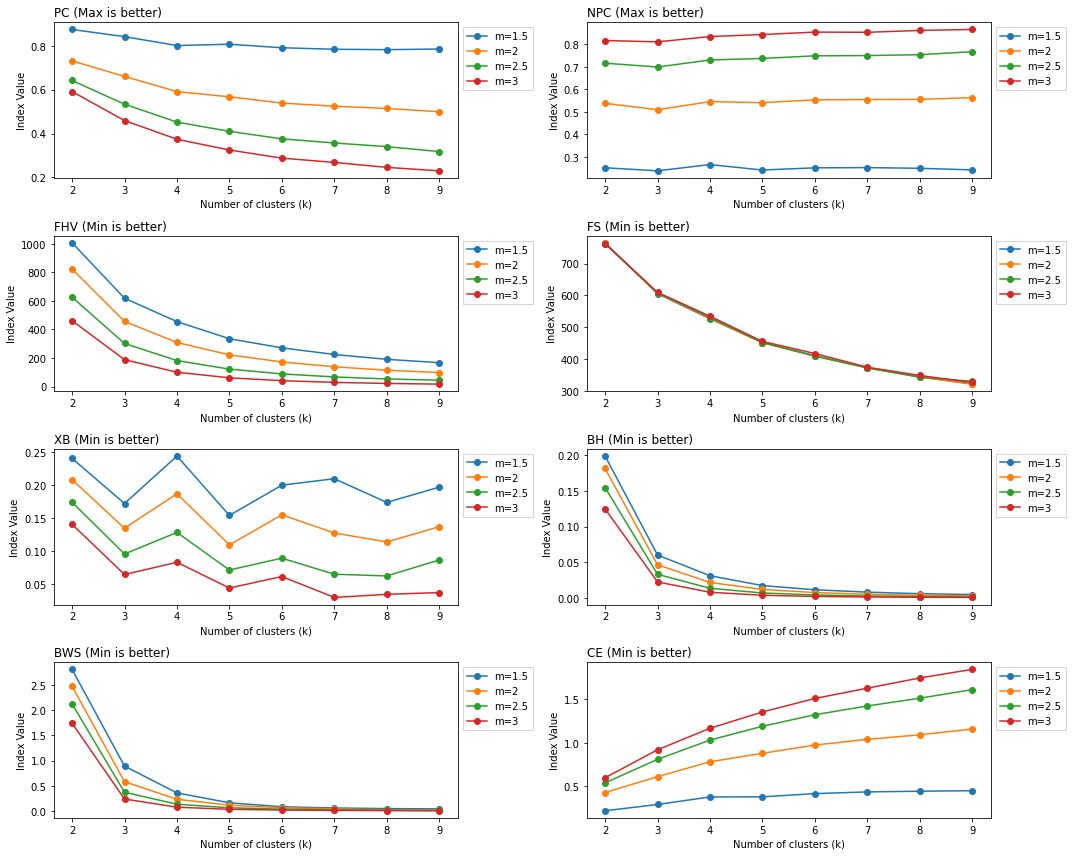

In [18]:
# Define which is better for each index: 'Min' or 'Max'
best_values = {
    'PC': 'Max',
    'NPC': 'Max',
    'FHV': 'Min',
    'FS': 'Min',
    'XB': 'Min',
    'BH': 'Min',
    'BWS': 'Min',
    'CE': 'Min'
}

# Plotting
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 12))

for ax, (label, values_for_each_m) in zip(axes.ravel(), results.items()):
    for idx, m in enumerate(m_values):
        ax.plot(k_values, [values_for_each_k[idx] for values_for_each_k in values_for_each_m], marker='o', label=f'm={m}')

    ax.set_title(f"{label} ({best_values[label]} is better)",loc='left')
    ax.set_xlabel('Number of clusters (k)')
    ax.set_ylabel('Index Value')
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fancybox=False)

    ax.set_xticks(range(min(k_values), max(k_values)+1))

plt.tight_layout()

plt.show()


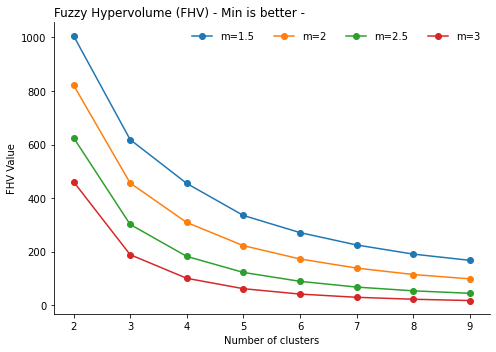

In [19]:
fig, ax = plt.subplots(figsize=(7, 5))

k_values = range(2, 10)  # Example: test from 2 to 9 clusters.
m_values = [1.5,2,2.5,3]  # Example: test these fuzziness coefficients.
for idx, m in enumerate(m_values):
    ax.plot(k_values, [values_for_each_k[idx] for values_for_each_k in results['FHV']], marker='o', label=f'm={m}')

ax.set_title(f"Fuzzy Hypervolume (FHV) - Min is better -", loc='left')
ax.set_xlabel('Number of clusters')
ax.set_ylabel('FHV Value')
ax.legend(loc='upper right',ncol=4,fancybox=False,framealpha=0)
ax.set_xticks(range(min(k_values), max(k_values) + 1))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()
plt.show()

## FCM with the best parameters

In [20]:
centroids, membership_weights = fuzzy_c_means(pca_df, k=4, m=3)

Algorithm converged after 123 iterations.


In [21]:
transformed_dimensions = transformed_dimensions.join(pca_df)
df_ = transformed_dimensions.copy()
C = centroids
weight= membership_weights

# Determine the assigned cluster for each data point
df_['assigned_cluster'] = np.argmax(weight, axis=1)
df_['max_weight'] = np.max(weight,axis=1)

# Create a DataFrame from the cluster centers
df_C = pd.DataFrame(C, columns=[f'centroid_dim_{i}' for i in range(0, C.shape[1])])

# Repeat the centroids for each data point based on its assigned cluster
df_['centroid'] = df_['assigned_cluster'].apply(lambda x: df_C.iloc[x].tolist())
df_centroids = df_['centroid'].apply(pd.Series)
df_centroids.columns = [f'centroid_dim_{i}' for i in range(0, C.shape[1] )]

# Include the membership weights in the dataframe
df_weights = pd.DataFrame(weight, columns=[f'weight_cluster_{i}' for i in range(0, C.shape[0])])

# Combine the original data, assigned cluster, weights, and repeated centroids
combined_df = pd.concat([df_, df_centroids, df_weights], axis=1).drop(columns='centroid')

In [22]:
a= combined_df.copy()
pca_re = combined_df[['Dimension 1','Dimension 2','assigned_cluster','weight_cluster_0','weight_cluster_1','weight_cluster_2'
                     ,'weight_cluster_3']].copy()
centroids= combined_df.groupby('assigned_cluster').first()[['centroid_dim_0','centroid_dim_1']].reset_index(drop=True)
display(centroids.head())

,centroid_dim_0,centroid_dim_1
0,1.53,-0.60
1,-0.87,0.92
2,0.64,0.46
3,-2.09,-1.14


In [23]:
pca_re.head()

,Dimension 1,Dimension 2,assigned_cluster,weight_cluster_0,weight_cluster_1,weight_cluster_2,weight_cluster_3
0,1.06,-0.60,0,0.57,0.11,0.24,0.08
1,1.73,-1.04,0,0.65,0.10,0.17,0.08
2,1.39,-0.62,0,0.83,0.04,0.09,0.03
3,1.37,-0.69,0,0.79,0.05,0.11,0.04
4,1.32,-0.52,0,0.75,0.06,0.14,0.05


In [24]:
centroids['assigned_cluster'] = ['High PC1 & Low PC2','Low PC1 & High PC2',
                       'High PC1 & High PC2','Low PC1 & Low PC2']
pca_re.head()
pca_re.rename(columns={'assigned_cluster':'Cluster'},inplace=True)
centroids.rename(columns={'assigned_cluster':'Cluster'},inplace=True)
display(centroids.head())

,centroid_dim_0,centroid_dim_1,Cluster
0,1.53,-0.60,High PC1 & Low PC2
1,-0.87,0.92,Low PC1 & High PC2
2,0.64,0.46,High PC1 & High PC2
3,-2.09,-1.14,Low PC1 & Low PC2


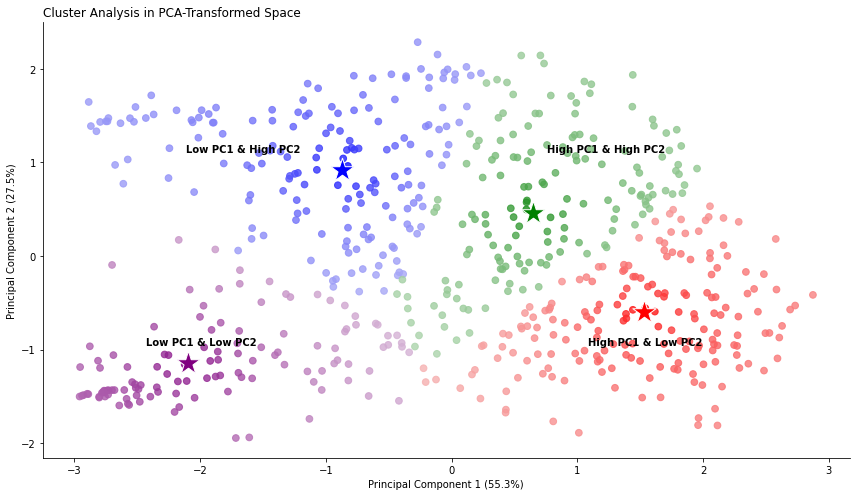

In [25]:
centroids_annotations = {
    0: {'coords': (1.95, -1.04), 'label': 'High PC1 & Low PC2'},  # Coordinates for centroid of cluster 0
    1: {'coords': (-1.25, 1.02), 'label': 'Low PC1 & High PC2'},  # Coordinates for centroid of cluster 1
    2: {'coords': (1.65, 1.02), 'label': 'High PC1 & High PC2'},   # Coordinates for centroid of cluster 2
    3: {'coords': (-1.60, -1.04), 'label': 'Low PC1 & Low PC2'}, # Coordinates for centroid of cluster 3
}


base_colors = ['red', 'blue', 'green', 'purple']

def assign_cluster_colors(row):
    cluster = int(row['Cluster'])  # Convert cluster number to integer
    weight_col = f'weight_cluster_{cluster}'
    weight = row[weight_col]
    color = sns.light_palette(base_colors[cluster], input="rgb", n_colors=200)[int(weight * 200)]
    return color

pca_re['color'] = pca_re.apply(assign_cluster_colors, axis=1)
plt.figure(figsize=(12, 7))
plt.scatter(pca_re['Dimension 1'], pca_re['Dimension 2'], color=pca_re['color'], s=45,alpha=0.8)

# Plot the centroids
for cluster_num, centroid in centroids.iterrows():
    plt.scatter(centroid['centroid_dim_0'], centroid['centroid_dim_1'], 
                color=base_colors[cluster_num], edgecolor='w', marker='*', s=600, label=f'Centroid {cluster_num}',
                alpha=1)

for cluster_num, centroid_info in centroids_annotations.items():
    plt.annotate(centroid_info['label'], 
                 xy=centroid_info['coords'], 
                 xytext=(6, 6), 
                 textcoords='offset points', 
                 ha='right', 
                 va='bottom',
                color='black',
                weight="bold")

plt.title("Cluster Analysis in PCA-Transformed Space",loc='left')
plt.xlabel('Principal Component 1 (55.3%)')
plt.ylabel('Principal Component 2 (27.5%)')

ax = plt.gca()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tight_layout()
plt.show()


In [26]:
pca_df_2['Cluster'] = combined_df['assigned_cluster'].copy()

In [27]:
transformed_dimensions.sample(3)

,Annual Sales,Seasonality,Capacity Ins.,Backorder T.,Dimension 1,Dimension 2
298,0.65,0.51,0.65,0.23,0.60,-0.75
76,0.52,0.30,0.15,0.73,-0.27,0.24
171,0.07,1.00,0.05,0.78,-2.68,0.97


In [28]:
a.rename(columns={'assigned_cluster':'Cluster'},inplace=True)
a.groupby('Cluster').first()[['centroid_dim_0','centroid_dim_1']]

,centroid_dim_0,centroid_dim_1
Cluster,,
0,1.53,-0.60
1,-0.87,0.92
2,0.64,0.46
3,-2.09,-1.14


In [29]:
transformed_dimensions['Cluster'] = pca_df_2['Cluster']
mapping = {
    0: 'High PC1 & Low PC2',
    1: 'Low PC1 & High PC2',
    2: 'High PC1 & High PC2',
    3: 'Low PC1 & Low PC2'
}
transformed_dimensions['Cluster'] = transformed_dimensions.Cluster.map(mapping)
bc = transformed_dimensions.copy()
mapping = {
    'High PC1 & Low PC2':'H PC1 & L PC2',
    'Low PC1 & High PC2': 'L PC1 & H PC2',
    'High PC1 & High PC2': 'H PC1 & H PC2',
    'Low PC1 & Low PC2': 'L PC1 & L PC2'
}
bc['Cluster'] = bc.Cluster.map(mapping)

## Insights

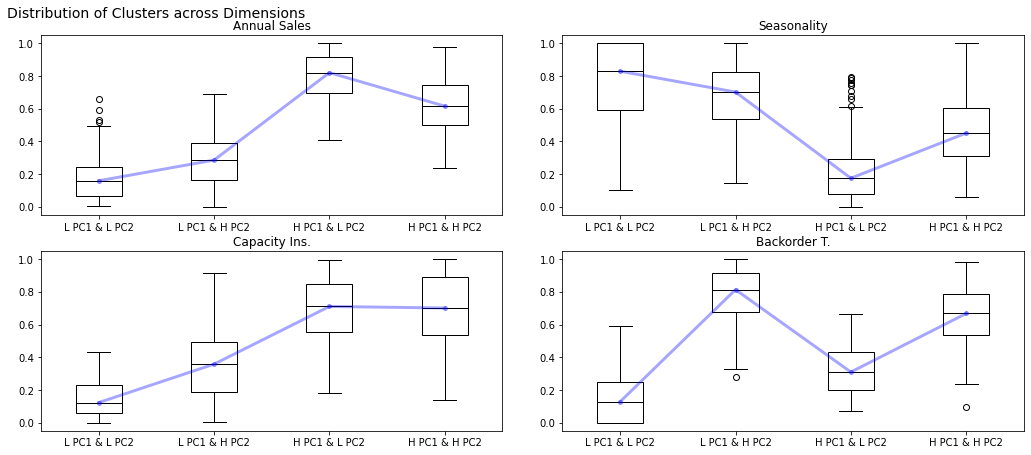

In [30]:
create_cluster_boxplots_v3(bc, bc['Cluster'])

In [31]:
transformed_dimensions.head()

,Annual Sales,Seasonality,Capacity Ins.,Backorder T.,Dimension 1,Dimension 2,Cluster
0,0.92,0.75,0.79,0.21,1.06,-0.60,High PC1 & Low PC2
1,0.94,0.50,0.89,0.11,1.73,-1.04,High PC1 & Low PC2
2,0.95,0.71,0.89,0.19,1.39,-0.62,High PC1 & Low PC2
3,0.89,0.68,0.92,0.16,1.37,-0.69,High PC1 & Low PC2
4,0.96,0.78,0.91,0.20,1.32,-0.52,High PC1 & Low PC2


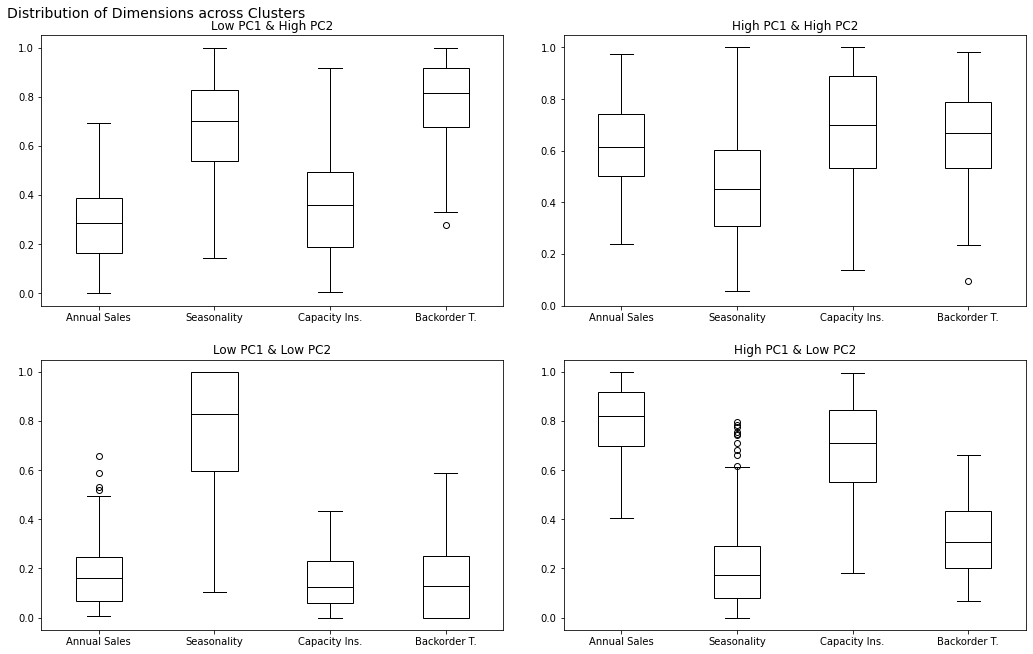

In [32]:
features= ['Annual Sales', 'Seasonality', 'Capacity Ins.', 'Backorder T.']
create_uniform_cluster_boxplots_v3(transformed_dimensions,  transformed_dimensions['Cluster'], features)